In [2]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [3]:
df, comment_df, names = create_dataframe(Path("../league_rounds/"))

In [4]:
df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)


If you want to convert the music league user names to real names create a translator dictionary like the one below. Otherwise set translator to `None`, or just delete the block below

In [5]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        comment_df = comment_df.replace(translator)
        comment_df = comment_df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [6]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Simply sorting the dataframe won't resolve ties correctly. The below one does

In [7]:
def resolve_podium(df) -> list[str]:
    """
    Resolve the winning order in case of draws in points. Resolution order is:
    1. Largest total positive votes
    2. Lowest number of down votes (not)
    """
    rankings = df.groupby("submitter")["round_score"].sum().rank(ascending=False).astype(int).sort_values()
    winning_order: list[str] = []

    rank = 1

    while rank != len(rankings) + 1:
        if len(rankings[rankings == rank]) > 1:
            tied_names = rankings[rankings == rank].index
            tie_break_df = df[df["submitter"].isin(tied_names)]
            tie_break_df.loc[:, names] = tie_break_df[names].map(lambda x: x if x > 0 else 0) # remove all downvotes
            positive_votes =  tie_break_df.groupby("submitter")[names].sum().sum(axis=1).sort_values()
            if len(set(positive_votes)) < len(positive_votes):
                print("Tie break unresolved, alphabetical order used")
            order = [k for k, _ in sorted(positive_votes.to_dict().items(), key=lambda item: item[1], reverse=True)]
            winning_order += order
            rank += len(order)
        else:
            winning_order.append((rankings[rankings==rank]).index[0])
            rank += 1
        if len(winning_order) == len(rankings):
            break
    return winning_order

winning_order = resolve_podium(df)


## Round Winners

Below we list all of the winners for each round

In [8]:
for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    a = f"Round     | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "song_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['song_name']:40} | {int(row['round_score'])}")
    print()


Round     | ⚓ Track related to a Riskaware core value
-----------------------------------------------------
Helen      | Ice Ice Baby                             | 20

Round     | 🌡 Can you quantify that
-----------------------------------
Jenny S    | Gay Bar                                  | 18
Fred       | The Chain - 2004 Remaster                | 18
Mel        | Hertz                                    | 18

Round     | 🍎 Song with a fruit in the title
--------------------------------------------
Una        | Bonita Applebum                          | 15
Jenny B    | First Date                               | 15

Round     | 🎩 Bristolian band
-----------------------------
Jenny S    | Brown Paper Bag (feat. Dynamite MC) - 2008 Re-edit | 15

Round     | 🎯 Darts walk on song
--------------------------------
Jenny B    | Bonkers                                  | 19

Round     | 🎸 Best instrumental
-------------------------------
Tim C      | Sandstorm                               

### Highest and lowest scores across the league's rounds

In [9]:
# highest
df.sort_values("round_score", ascending=False).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
40,👇 Straight to the point,Tim C,Ready or Not,26.0
60,⚓ Track related to a Riskaware core value,Helen,Ice Ice Baby,20.0
139,🎯 Darts walk on song,Jenny B,Bonkers,19.0
158,💘 Best love song,Russell,Can't Take My Eyes Off You,19.0
0,🎸 Best instrumental,Tim C,Sandstorm,18.0
180,🌡 Can you quantify that,Mel,Hertz,18.0
178,🌡 Can you quantify that,Jenny S,Gay Bar,18.0
179,🌡 Can you quantify that,Fred,The Chain - 2004 Remaster,18.0
80,🔢 Numerical track,Fred,Disco 2000,17.0
1,🎸 Best instrumental,Andrej,Children,17.0


In [10]:
# lowest
df.sort_values("round_score", ascending=True).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
39,🍎 Song with a fruit in the title,Sam,The Christmas Song (Chestnuts Roasting on an O...,-10.0
99,🔢 Numerical track,Peter R,2004,-10.0
197,🌡 Can you quantify that,Tim P,Butt Cheeks Butt Cheeks Butt Cheeks!,-10.0
157,🎯 Darts walk on song,Jamie,Run Boy Run - Instrumental,-7.0
177,💘 Best love song,Sacha,KKK B***h,-5.0
196,🌡 Can you quantify that,murray,Two Doors Down,-5.0
38,🍎 Song with a fruit in the title,Peter R,Strawberry Fields Forever - Remastered 2009,-4.0
59,👇 Straight to the point,Mel,Dude (Looks Like A Lady),-4.0
77,⚓ Track related to a Riskaware core value,Mel,I Think I'm Going To Kill Myself,-4.0
138,🤝 Most surprising collaboration,Peter R,Movement 6,-4.0


## Voting Matrix

The voting matrix shows the cumlative votes given between every player across all of the rounds.

In [11]:
# arr has shape (num_rounds, num_competitors, num_competitors)
# Any missing values are filled with 0.0

arr: list[np.ndarray] = []
for _, a in df.set_index("submitter").groupby("round")[winning_order]:
    a = a.reindex(winning_order).fillna(0).to_numpy()
    arr.append(a[None, :, :])

arr = np.concat(arr)
voting_matrix = np.sum(arr, axis=0)

Rows are the points received, columns the points given. The rows and columns are sorted into the final order of the league

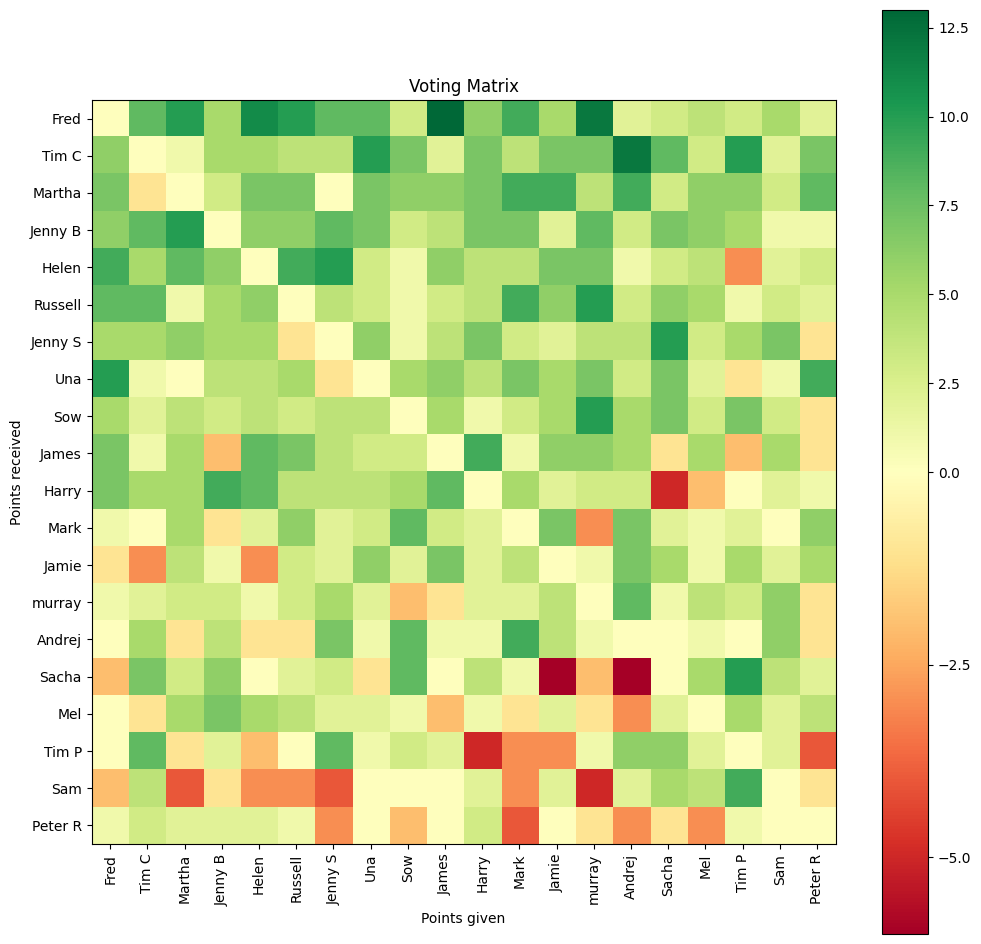

In [12]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.xlabel("Points given")
plt.ylabel("Points received")
plt.title("Voting Matrix")


cbar = plt.colorbar()

plt.show()

In [13]:
# Biggest differences 

reciprocals = np.abs((np.triu(voting_matrix) - np.tril(voting_matrix).T))
diffs = np.unravel_index(np.argsort(reciprocals.reshape(-1))[::-1][:10], reciprocals.shape)

for row, col in zip(*diffs):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

murray for Sow: 10
Sacha for Jamie: 5
Sam for murray: 6
Sam for Jenny S: 7
murray for Fred: 12
Jamie for Helen: 7
Andrej for Martha: 9
Peter R for Mark: 6
Jamie for Tim C: 7
Peter R for Una: 9


### Biggest Stans and biggest haters

In [14]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[::-1][:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

James for Fred: 13
murray for Fred: 12
Andrej for Tim C: 12
Helen for Fred: 11
Tim P for Tim C: 10
Jenny S for Helen: 10
Una for Tim C: 10
Tim P for Sacha: 10
Martha for Jenny B: 10
Martha for Fred: 10


In [15]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Andrej for Sacha: -6
Jamie for Sacha: -6
murray for Sam: -5
Harry for Tim P: -5
Sacha for Harry: -5
Martha for Sam: -4
Jenny S for Sam: -4
Peter R for Tim P: -4
Mark for Peter R: -4
Andrej for Mel: -3


## Voting Correlation

This shows who votes similarly, and who doesn't. Note that the matrix is symmetrical

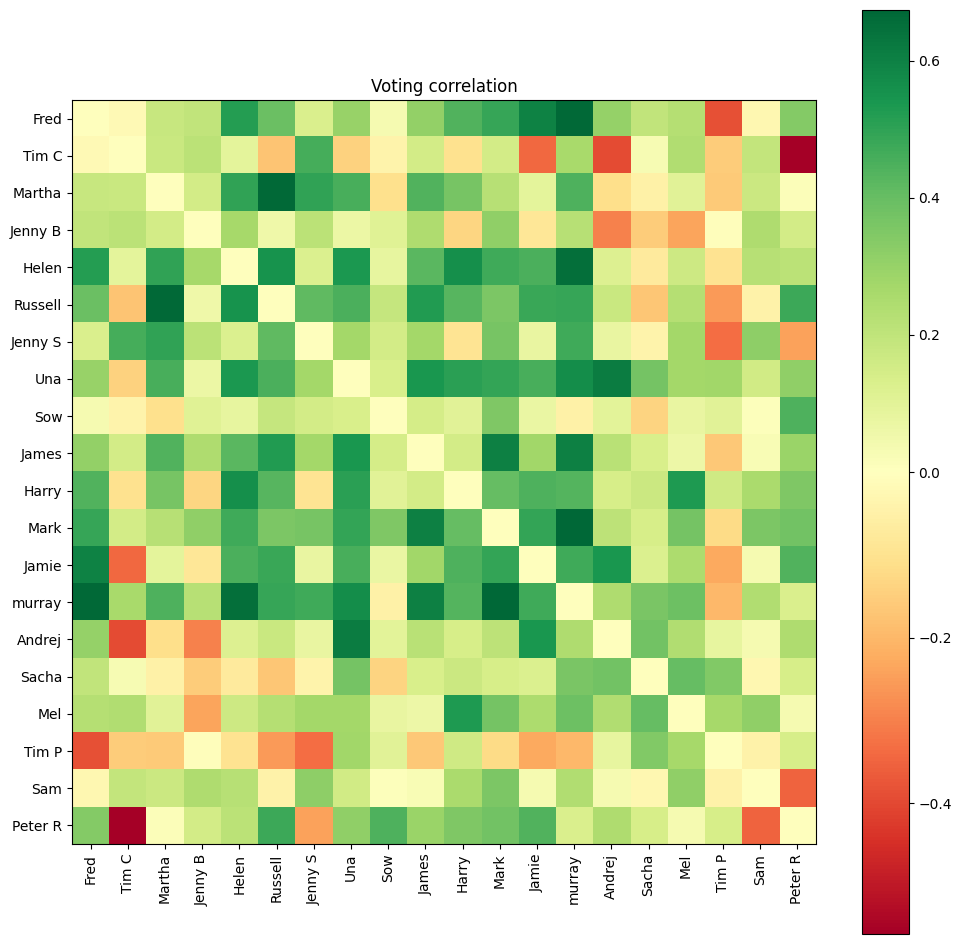

In [16]:
# Sort arr into an array that's lists of each competitors votes per round

voting_correlation = np.corrcoef(np.vstack(voting_matrix).T)
np.fill_diagonal(voting_correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_correlation),
                        vcenter=0,
                        vmax=np.max(voting_correlation))

plt.imshow(voting_correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Voting correlation")


cbar = plt.colorbar()

plt.show()

### Most and least voting-correlated

In [17]:
most_correlated = np.unravel_index(np.argsort(-voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Mark and murray: 0.67
Martha and Russell: 0.67
murray and Fred: 0.66
murray and Helen: 0.65
Una and Andrej: 0.61
murray and James: 0.61
James and Mark: 0.60
Fred and Jamie: 0.60
murray and Una: 0.56
Harry and Helen: 0.56


In [18]:
least_correlated = np.unravel_index(np.argsort(voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Peter R and Tim C: -0.56
Andrej and Tim C: -0.39
Tim P and Fred: -0.39
Sam and Peter R: -0.35
Jamie and Tim C: -0.34
Tim P and Jenny S: -0.33
Andrej and Jenny B: -0.30
Tim P and Russell: -0.26
Jenny S and Peter R: -0.24
Jenny B and Mel: -0.24


## Genre Correlation

See who submitted similar genres. Note that Spotify's list of genres is pretty wild, so this is pretty rough

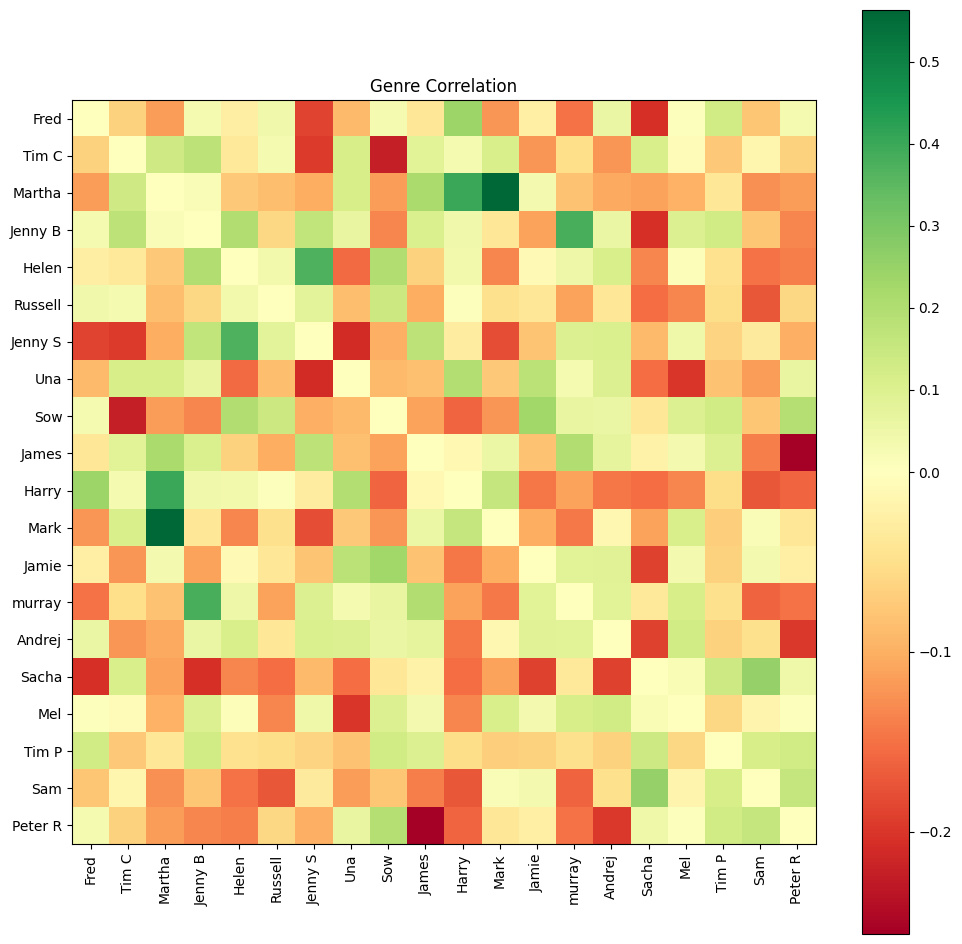

In [19]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique_genres |= set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)

all_genres = list({genre for genres in df.genres for genre in genres}.difference(unique_genres))

x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

genre_matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            genre_matrix[i][j] = 1.0

voting_matrix = np.corrcoef(genre_matrix)
np.fill_diagonal(voting_matrix, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Genre Correlation")


cbar = plt.colorbar()

plt.show()

### Most and least genre correlated

In [20]:
most_genre_correlated = np.unravel_index(np.argsort(-voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Mark and Martha: 0.56
Martha and Harry: 0.40
murray and Jenny B: 0.38
Jenny S and Helen: 0.37
Sacha and Sam: 0.25
Harry and Fred: 0.24
Jamie and Sow: 0.23
Martha and James: 0.21
James and murray: 0.20
Sow and Helen: 0.20


In [21]:
least_genre_correlated = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Peter R and James: -0.26
Tim C and Sow: -0.22
Jenny S and Una: -0.21
Sacha and Fred: -0.21
Fred and Sacha: -0.21
Mel and Una: -0.20
Peter R and Andrej: -0.20
Tim C and Jenny S: -0.20
Sacha and Jamie: -0.19
Sacha and Andrej: -0.19


## Average positive vote given out

Look at who chunks their votes into lumps vs those who scatter their votes like chicken feed

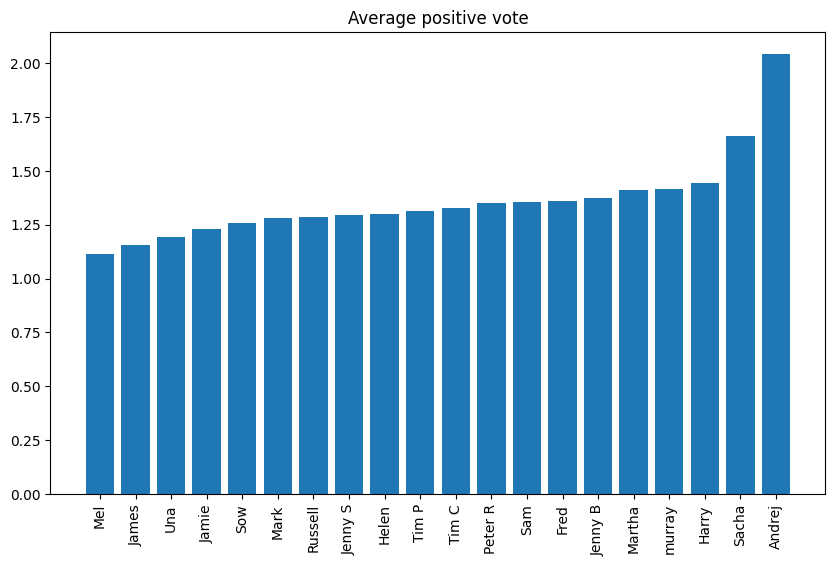

In [22]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

## Average song age

Plot every players average song age with respect to today (or when this notebook was run). Note that the accuracy of date on some songs is worse than others (year vs month vs day, so this isn't 100% accurate)

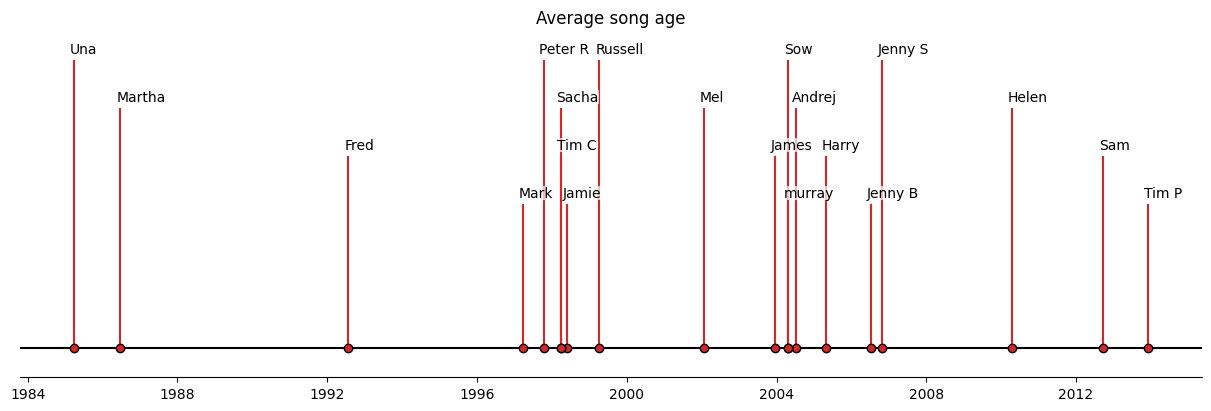

In [23]:
df["song_age_seconds"] = (datetime.now() - df["release_date"]).dt.total_seconds()
ages = df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
ax.set(title="Average song age")

levels = [(i % 4) / 3 + 1 for i in range(len(ages))]

# The vertical stems.
ax.vlines(ages, 0, levels,
          color=[("tab:red", 1)
                 for _ in ages])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline
ax.plot(ages, np.zeros_like(ages), "ko", mfc="tab:red")

# Annotate the lines.
for date, level, name in zip(ages, levels, ages.index):
    ax.annotate(name, xy=(date, level),
                xytext=(-3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom" if level > 0 else "top",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

ax.yaxis.set(major_locator=mdates.YearLocator(),
             major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [24]:
oldest = df.groupby("submitter")["song_age_seconds"].max().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()
youngest = df.groupby("submitter")["song_age_seconds"].min().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()

oldest_oldest = df.iloc[df[df["submitter"] == oldest.index[0]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_oldest = df.iloc[df[df["submitter"] == oldest.index[-1]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_youngest = df.iloc[df[df["submitter"] == youngest.index[-1]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]
oldest_youngest = df.iloc[df[df["submitter"] == youngest.index[0]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]

print(oldest_youngest.to_list())


['Una', Timestamp('2007-12-28 00:00:00'), 'Here Comes the Hotstepper']


In [25]:
# does song age correlate with overall position

np.corrcoef(np.c_[ages.reindex(winning_order).argsort(), np.arange(len(ages))].T)

array([[1.        , 0.24360902],
       [0.24360902, 1.        ]])

### Mean song length

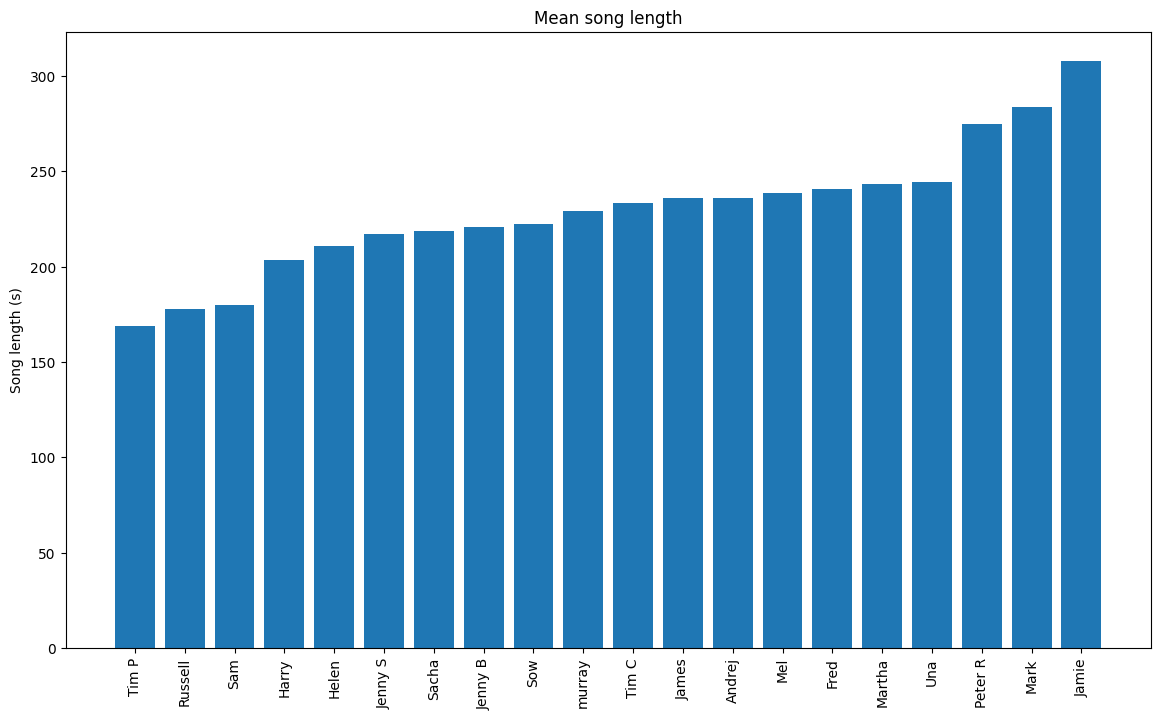

In [26]:
lengths = df.groupby("submitter")["duration_s"].mean().sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(len(lengths)), lengths)
ax.set_xticks(np.arange(len(winning_order)), lengths.index, rotation='vertical')
ax.set_title("Mean song length")
ax.set_ylabel("Song length (s)")
plt.show()

In [27]:
# Correlation between mean song length and overall league rank
np.corrcoef(lengths.reindex(winning_order).rank(), np.arange(1, len(winning_order)+1))


array([[ 1.        , -0.03007519],
       [-0.03007519,  1.        ]])

### Longest and shortest songs

In [28]:
df.sort_values("duration_s", ascending=False)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
5,Jamie,Mogwai Fear Satan,979.560
138,Peter R,Movement 6,530.894
27,Jamie,Watermelon Man - Remastered 2007,429.266
52,Mark,Hey Jude - Remastered 2015,425.653
37,Mel,Rotten Apple,418.466
136,Andrej,Stan - Live At 43rd Grammy Awards,380.280
156,Mark,Inside,379.413
183,Una,Like a Rolling Stone,369.600
92,Sacha,Forty Six & 2,363.066
16,Una,Birdland,356.760


In [29]:
df.sort_values("duration_s", ascending=True)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
36,Sacha,I Am a Banana,39.026
30,Russell,Porcupine or Pineapple,64.825
55,Russell,Come On!,68.133
57,Tim P,Cheese Tax,68.928
118,Sam,Cheese,84.767
17,Sam,Pre-Hibernation - Instrumental,89.026
91,Andrej,The 59th Street Bridge Song (Feelin' Groovy),103.560
173,Peter R,True Love Will Find You in the End,111.170
69,Jamie,A Kiss Is Not A Contract,114.946
197,Tim P,Butt Cheeks Butt Cheeks Butt Cheeks!,117.906


## Rankings if only downvotes/upvotes counted

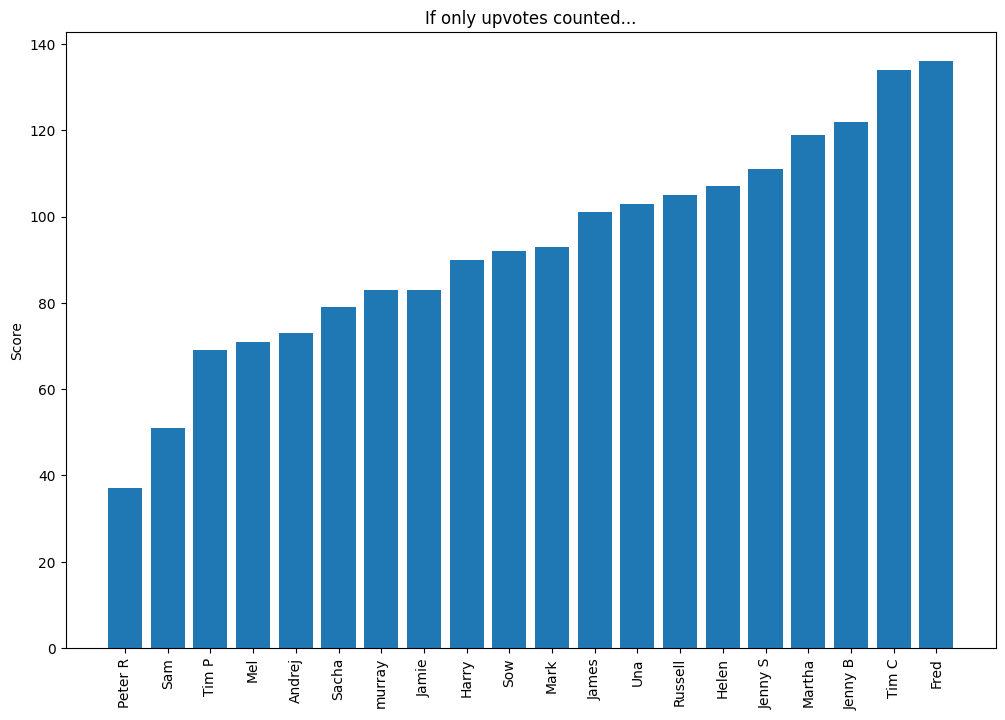

In [30]:
positive_votes = np.where(arr > 0, arr, 0)

positive_scores = np.sum(positive_votes, axis=(0, 2))

order = np.argsort(positive_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(positive_scores))
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only upvotes counted...")

plt.show()

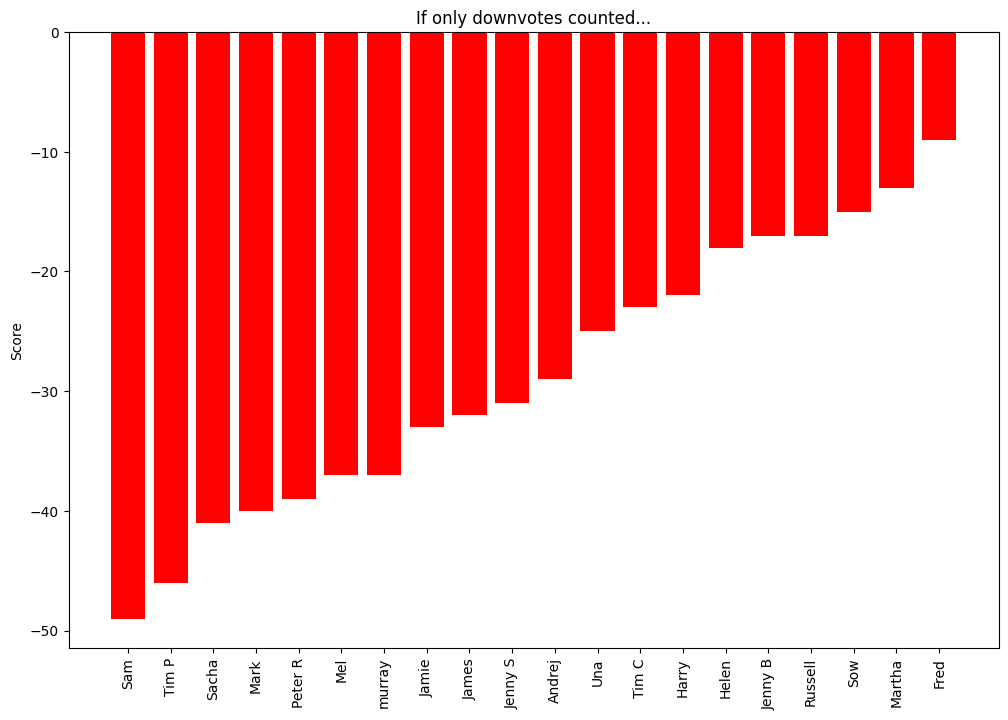

In [31]:
negative_votes = np.where(arr < 0, arr, 0)

negative_scores = np.sum(negative_votes, axis=(0, 2))

order = np.argsort(negative_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(negative_scores), color="red")
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only downvotes counted...")

plt.show()

## Controversy score

The controversy score aims to find the most controversial songs, those with the highest numbers of upvotes and downvotes leaving a score near 0

The controversy score $C$ is calculated using the following formula:


$C = \sqrt{\frac{1}{N_{\neq 0}} \sum_{i=1}^{N_{\neq 0}} (v_i - \mu)^2} \times \left( \sum_{i=1}^{n} v_i \text{ where } v_i > 0 \ - \ \alpha \sum_{i=1}^{n} v_i \text{ where } v_i < 0 \right)$


Where:
- $v_i$ are the individual votes.
- $\mu$ is the mean of the non-zero votes.
- $N_{\neq 0}$ is the number of non-zero votes.
- $\alpha$ is the ratio of positive to negative votes ($\frac{10}{3}$ in this league)
- The first part of the equation represents the standard deviation of the non-zero votes.
- The second part represents a modified range that accounts for positive and scaled negative votes.


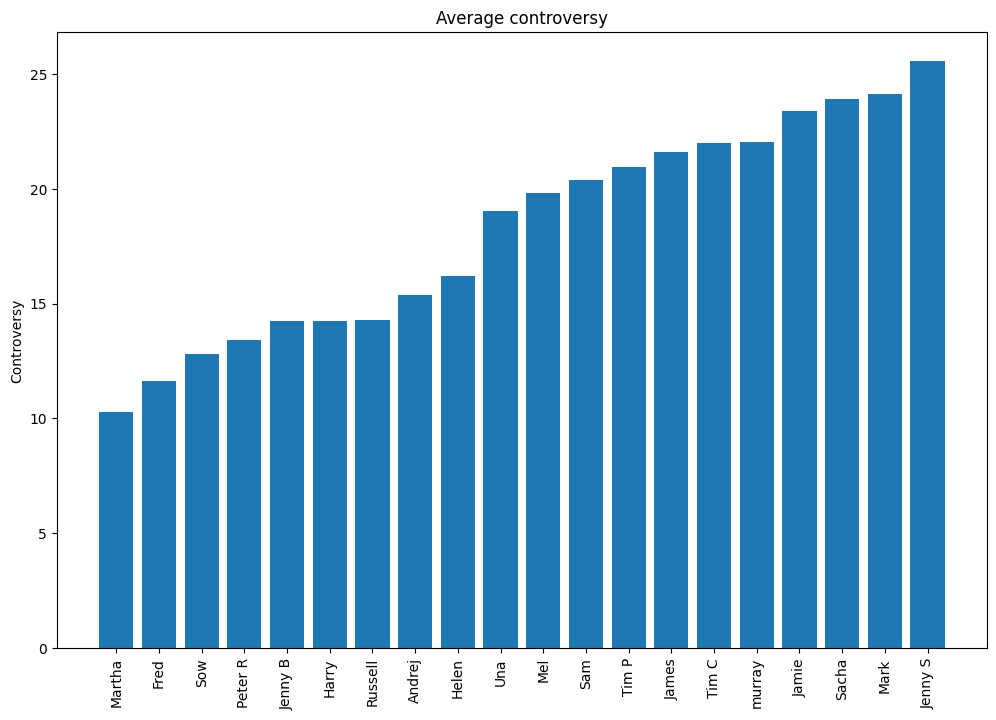

In [32]:
def controversy(vals):
    std = np.std([i for i in vals if i])
    range = sum(i for i in vals if i > 0.0) - (sum(i for i in vals if i < 0.0) * 10/3)
    return std * range

df["controversy"] = df[names].fillna(0).apply(controversy, axis=1)
df.sort_values("controversy", ascending=False)[["submitter", "song_name", "round", "controversy"]].iloc[:10]

fig, ax = plt.subplots(figsize=(12, 8))

vals = df.groupby("submitter")["controversy"].mean().sort_values()

ax.bar(np.arange(len(vals)), vals)
ax.set_xticks(range(len(vals)), vals.index, rotation="vertical")
ax.set_ylabel("Controversy")
ax.set_title("Average controversy")

plt.show()

In [33]:
df.sort_values("controversy", ascending=False)[["controversy", "submitter", "round", "song_name"]].iloc[:10]

,controversy,submitter,round,song_name
5,64.466759,Jamie,🎸 Best instrumental,Mogwai Fear Satan
118,55.414285,Sam,🎩 Bristolian band,Cheese
177,49.020404,Sacha,💘 Best love song,KKK B***h
17,48.294651,Sam,🎸 Best instrumental,Pre-Hibernation - Instrumental
193,46.962086,Jamie,🌡 Can you quantify that,I'm Gonna Be (500 Miles)
169,44.580358,Jenny S,💘 Best love song,"Accidentally In Love - From ""Shrek 2"" Soundtrack"
12,42.253452,Jenny S,🎸 Best instrumental,Mii Channel
75,40.901458,James,⚓ Track related to a Riskaware core value,Reach for the Sky (Biome Remix) [LVL 38.2]
197,40.753626,Tim P,🌡 Can you quantify that,Butt Cheeks Butt Cheeks Butt Cheeks!
137,39.636154,Tim C,🤝 Most surprising collaboration,Breakn' a Sweat


In [34]:
print("Number of explicit songs submitted")
df.groupby("submitter")["explicit"].sum().sort_values(ascending=False)

Number of explicit songs submitted


submitter
Sacha      3
Mel        2
James      2
Sam        2
Tim C      2
Tim P      2
murray     2
Fred       1
Sow        1
Jenny B    1
Andrej     0
Harry      0
Helen      0
Peter R    0
Mark       0
Jenny S    0
Jamie      0
Martha     0
Russell    0
Una        0
Name: explicit, dtype: int64

In [35]:
# Every explicit song
df[df["explicit"]][["submitter", "round", "song_name", "artist_names"]]

,submitter,round,song_name,artist_names
40,Tim C,👇 Straight to the point,Ready or Not,"[Fugees, Ms. Lauryn Hill, Wyclef Jean, Pras]"
58,Sam,👇 Straight to the point,AHHHH!,[Teen Jesus and the Jean Teasers]
62,Fred,⚓ Track related to a Riskaware core value,Let's Push Things Forward,[The Streets]
66,Sacha,⚓ Track related to a Riskaware core value,Know Your Enemy,[Rage Against The Machine]
67,Tim P,⚓ Track related to a Riskaware core value,Who's That What's That,[Niko B]
73,Jenny B,⚓ Track related to a Riskaware core value,Pay Me,[The Philharmonik]
75,James,⚓ Track related to a Riskaware core value,Reach for the Sky (Biome Remix) [LVL 38.2],[LEVELZ]
79,Sam,⚓ Track related to a Riskaware core value,Riding Solo,[Hinds]
90,Mel,🔢 Numerical track,212,"[Azealia Banks, Lazy Jay]"
93,Tim C,🔢 Numerical track,7 Words,[Deftones]


## League Rankings over time

/tmp/ipykernel_60122/4037308044.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab20", len(submitters))  # or "tab10", "Set1", etc.


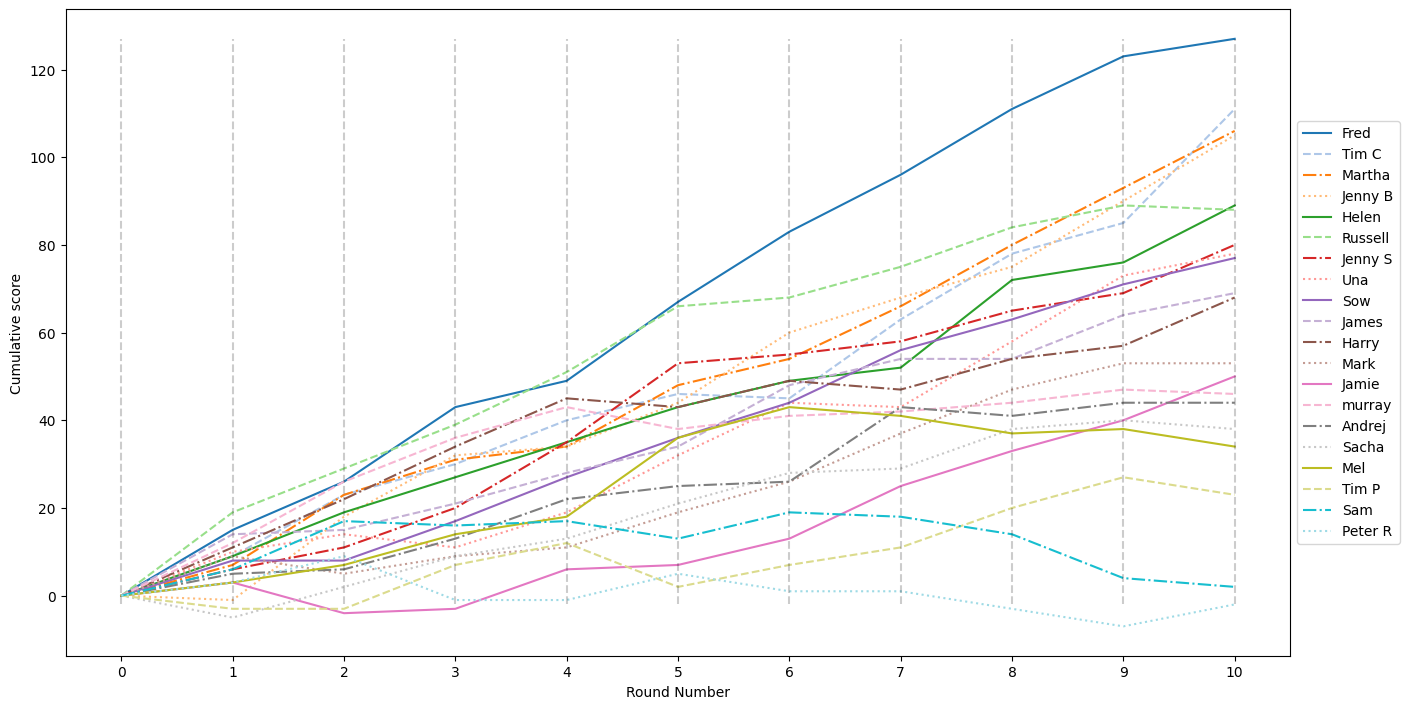

In [36]:
fig, ax = plt.subplots(figsize=(14, 7))

# Get a list of unique submitters
submitters = df["submitter"].unique()
colors = cm.get_cmap("tab20", len(submitters))  # or "tab10", "Set1", etc.
linestyles = ['-', '--', '-.', ':']

scores: dict[list[int]] = {name: [0] for name in winning_order}
df = df.sort_values("round_number")
for round, round_df in df.groupby("round_number"):
    round_scores = round_df.groupby("submitter")["round_score"].first().to_dict()
    for name in winning_order:
        scores[name].append(round_scores.get(name, 0))

for i, (name, round_scores) in enumerate(scores.items()):
    color = colors(i)
    linestyle = linestyles[i % len(linestyles)]
    ax.plot(list(np.cumsum(round_scores)), label=name, color=color, linestyle=linestyle)

# Move the legend outside the plot to the right
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()  # Adjust layout to make room for the legend

plt.xticks(range(df["round_number"].max() + 1))
plt.vlines(range(df["round_number"].max() + 1),
           min(map(lambda x: np.cumsum(x)[-1], scores.values())),
           max(map(lambda x: np.cumsum(x)[-1], scores.values())),
           'k', linestyles='--', alpha=0.2)

plt.xlabel("Round Number")
plt.ylabel("Cumulative score")

plt.show()

## Points Received Distribution

The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. The whiskers extend from the box to the farthest data point lying within 1.5x the inter-quartile range (IQR) from the box. Flier points are those past the end of the whiskers

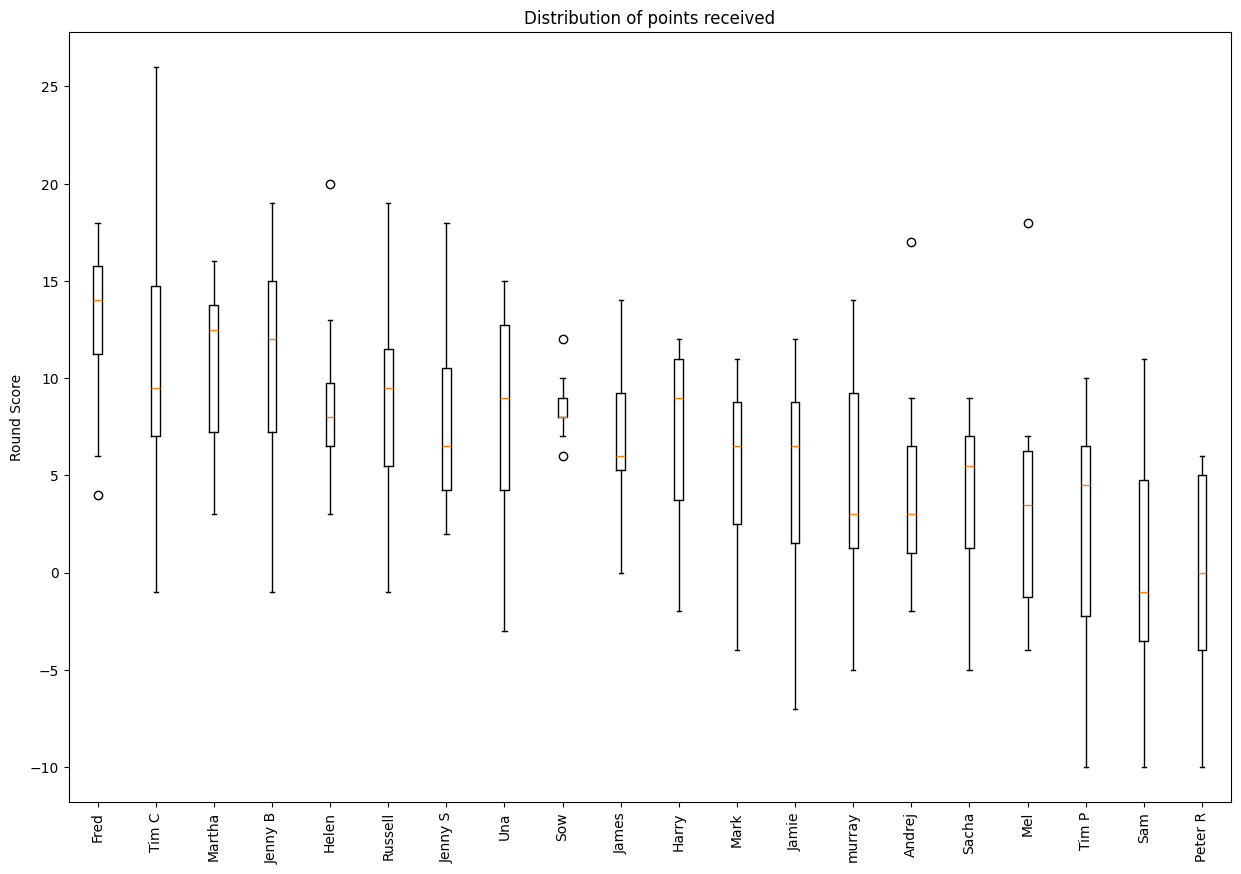

In [55]:
fig, ax = plt.subplots(figsize=(15,10))

for i, submitter in enumerate(winning_order):
    ax.boxplot(df[df["submitter"] == submitter]["round_score"], positions=[i])

plt.title("Distribution of points received")
plt.ylabel("Round Score")
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')


plt.show()

### One hit wonders

Who had the biggest outlier from their usual scoring

In [ ]:
means = df.groupby("submitter")["round_score"].mean().to_dict()
stds = df.groupby("submitter")["round_score"].std().to_dict()
df["std_distance"] = (df["round_score"] - df["submitter"].map(means)) / df["submitter"].map(stds)
df.loc[df.groupby("submitter")["std_distance"].idxmax()].sort_values("std_distance", ascending=False)[["submitter", "song_name", "round_score", "std_distance"]]

,submitter,song_name,round_score,one_hit
60,Helen,Ice Ice Baby,20.0,2.293010
1,Andrej,Children,17.0,2.281916
180,Mel,Hertz,18.0,2.233996
40,Tim C,Ready or Not,26.0,1.989321
3,Sow,Clubbed To Death - Kurayamino Variation,12.0,1.979508
178,Jenny S,Gay Bar,18.0,1.897367
143,Sam,Live And Let Die,11.0,1.779253
158,Russell,Can't Take My Eyes Off You,19.0,1.722475
141,murray,"Ooh Wee (feat. Ghostface Killah, Nate Dogg, Tr...",14.0,1.560896
160,James,Just The Way You Are,14.0,1.510296


### One hit blunders

In [61]:
df["std_distance"] = (df["submitter"].map(means) - df["round_score"]) / df["submitter"].map(stds)
df.loc[df.groupby("submitter")["std_distance"].idxmax()].sort_values("std_distance", ascending=False)[["submitter", "song_name", "round_score", "std_distance"]]

,submitter,song_name,round_score,std_distance
157,Jamie,Run Boy Run - Instrumental,-7.0,2.136207
156,Mark,Inside,-4.0,1.943413
197,Tim P,Butt Cheeks Butt Cheeks Butt Cheeks!,-10.0,1.923284
51,Fred,Golden Years - 2016 Remaster,4.0,1.883115
177,Sacha,KKK B***h,-5.0,1.878064
115,Martha,Marble Walls,3.0,1.778214
175,Jenny B,10 Years,-1.0,1.773316
99,Peter R,2004,-10.0,1.736795
98,Una,Ol' 55,-3.0,1.685307
39,Sam,The Christmas Song (Chestnuts Roasting on an O...,-10.0,1.680406


## Essay Writers

Who writes the most text, either in their song info, or in the comments.

In [63]:
word_counts = (
    comment_df.groupby("submitter")["submitter_comment"]
    .apply(lambda comments: comments.str.split().str.len().sum())
).sort_values(ascending=False)

word_counts

submitter
Harry      192
Tim C      122
Mark        91
Una         85
Jenny B     74
Russell     72
James       71
Peter R     53
Sam         52
Helen       50
Tim P       47
Jenny S     44
Fred        36
murray      25
Sow         23
Mel         18
Sacha       13
Martha       9
Andrej       3
Jamie        0
Name: submitter_comment, dtype: int64

In [67]:
comment_counts = comment_df[winning_order].apply(lambda comments: comments.str.split().str.len().sum(), axis=0).sort_values(ascending=False)
comment_counts

Russell    403
Jenny B    318
Harry      271
Fred       271
Una        251
Mark       245
murray      85
Tim C       79
Helen       79
Mel         60
Jenny S     55
James       39
Martha      20
Tim P       19
Sow          9
Andrej       9
Peter R      6
Jamie        0
Sacha        0
Sam          0
dtype: int64